## PyTorch Conditional GAN

This kernel is a PyTorch implementation of [Conditional GAN](https://arxiv.org/abs/1411.1784), which is a GAN that allows you to choose the label of the generated image. The generator and the discriminator are going to be simple feedforward networks, so I guess the images won't be as good as in this [nice kernel](https://www.kaggle.com/sgamez/fashion-ac-gan-with-keras) by [Sergio Gámez](https://www.kaggle.com/sgamez). I used [this implementation](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py) by [eriklindernoren](https://github.com/eriklindernoren) as inspiration.

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

 Let's start by defining a Dataset class:
* [Data Loading and Processing Tutorial on PyTorch's documentation](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* [torchvision](https://github.com/pytorch/vision) has a [built-in class for Fashion MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist)

In [2]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('../input/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [3]:
dataset = FashionMNIST()
dataset[0][0]

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Now let's define the generator and the discriminator, which are simple MLPs. I'm going to use an embedding layer for the label:

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [7]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [8]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [9]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data[0]

In [10]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data[0]

Starting epoch 0...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.


g_loss: 4.393280029296875, d_loss: 0.0984145998954773


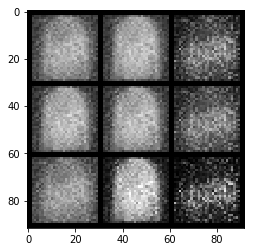

Starting epoch 1...
g_loss: 5.008516311645508, d_loss: 0.35589390993118286


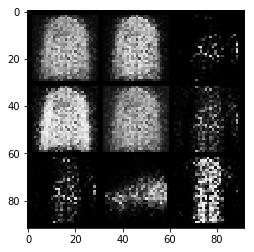

Starting epoch 2...
g_loss: 3.6078691482543945, d_loss: 1.420876383781433


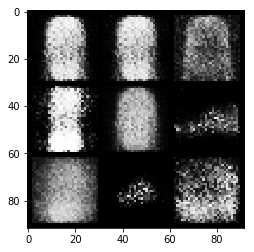

Starting epoch 3...
g_loss: 4.264520168304443, d_loss: 0.671290934085846


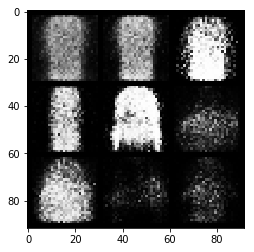

Starting epoch 4...
g_loss: 2.284855365753174, d_loss: 0.4984235167503357


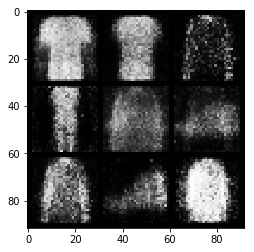

Starting epoch 5...
g_loss: 2.3497889041900635, d_loss: 0.5050001740455627


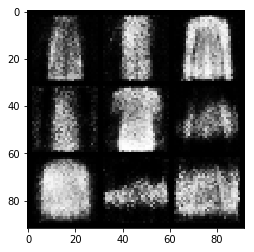

Starting epoch 6...
g_loss: 1.6053394079208374, d_loss: 0.6753461360931396


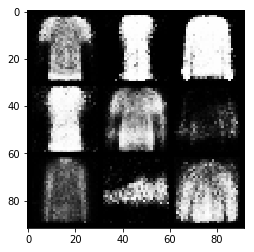

Starting epoch 7...
g_loss: 1.6775952577590942, d_loss: 0.6978068947792053


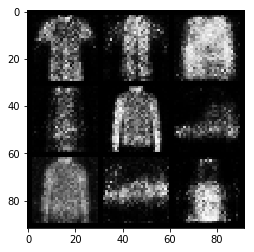

Starting epoch 8...
g_loss: 1.6103874444961548, d_loss: 0.9913121461868286


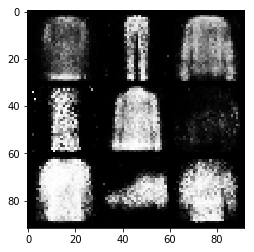

Starting epoch 9...
g_loss: 1.822489857673645, d_loss: 0.6959144473075867


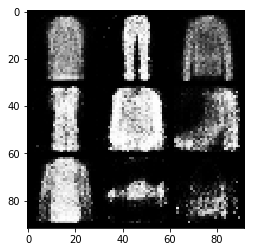

Starting epoch 10...
g_loss: 2.174344778060913, d_loss: 0.7071644067764282


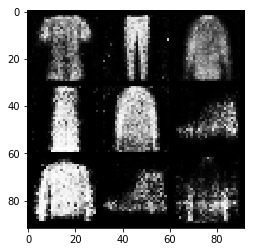

Starting epoch 11...
g_loss: 1.7915735244750977, d_loss: 0.87660813331604


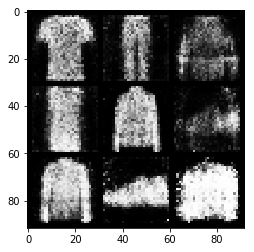

Starting epoch 12...
g_loss: 1.486160397529602, d_loss: 1.0854432582855225


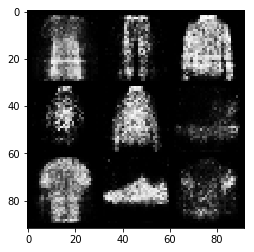

Starting epoch 13...
g_loss: 1.748167872428894, d_loss: 1.0580103397369385


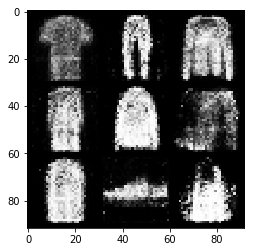

Starting epoch 14...
g_loss: 1.9502532482147217, d_loss: 0.9133474826812744


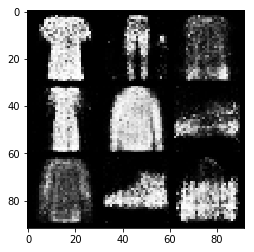

Starting epoch 15...
g_loss: 1.3762729167938232, d_loss: 0.6284093856811523


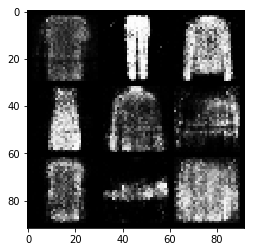

Starting epoch 16...
g_loss: 1.4583728313446045, d_loss: 0.8533560037612915


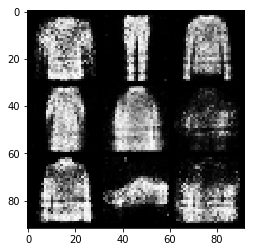

Starting epoch 17...
g_loss: 1.4635224342346191, d_loss: 0.9586190581321716


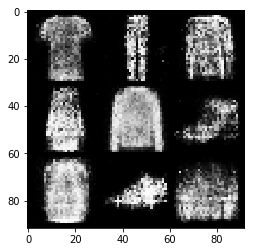

Starting epoch 18...
g_loss: 1.2845854759216309, d_loss: 1.2678651809692383


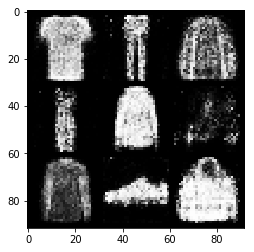

Starting epoch 19...
g_loss: 1.577878713607788, d_loss: 0.6641459465026855


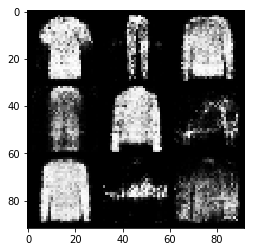

Starting epoch 20...
g_loss: 1.0670559406280518, d_loss: 1.1412627696990967


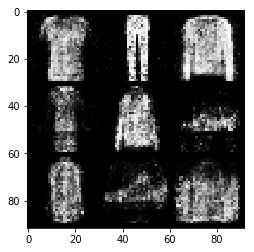

Starting epoch 21...
g_loss: 1.1643996238708496, d_loss: 0.9914550185203552


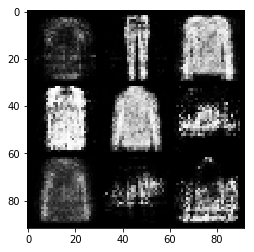

Starting epoch 22...
g_loss: 1.3266323804855347, d_loss: 0.9301960468292236


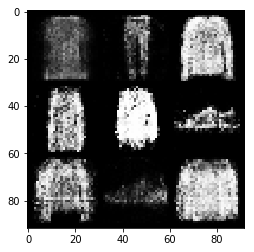

Starting epoch 23...
g_loss: 1.1165242195129395, d_loss: 1.142602801322937


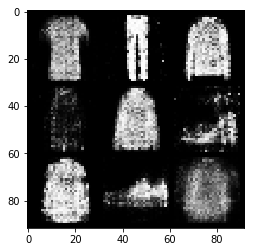

Starting epoch 24...
g_loss: 0.9820278882980347, d_loss: 1.0148464441299438


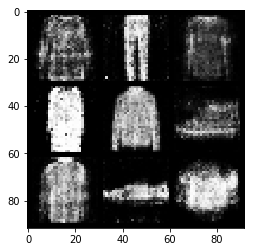

Starting epoch 25...
g_loss: 1.2836346626281738, d_loss: 1.1647573709487915


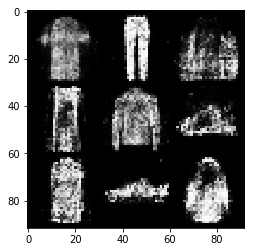

Starting epoch 26...
g_loss: 1.2358957529067993, d_loss: 0.9697952270507812


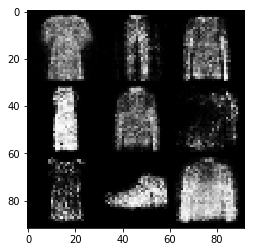

Starting epoch 27...
g_loss: 1.2008088827133179, d_loss: 1.050560712814331


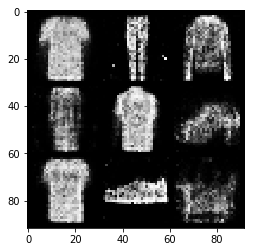

Starting epoch 28...
g_loss: 1.3043413162231445, d_loss: 0.935874342918396


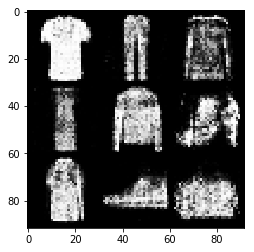

Starting epoch 29...
g_loss: 1.1933836936950684, d_loss: 0.8982100486755371


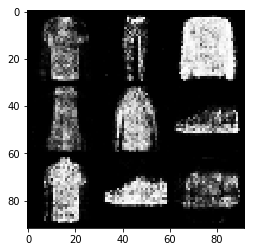

In [11]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

## Results

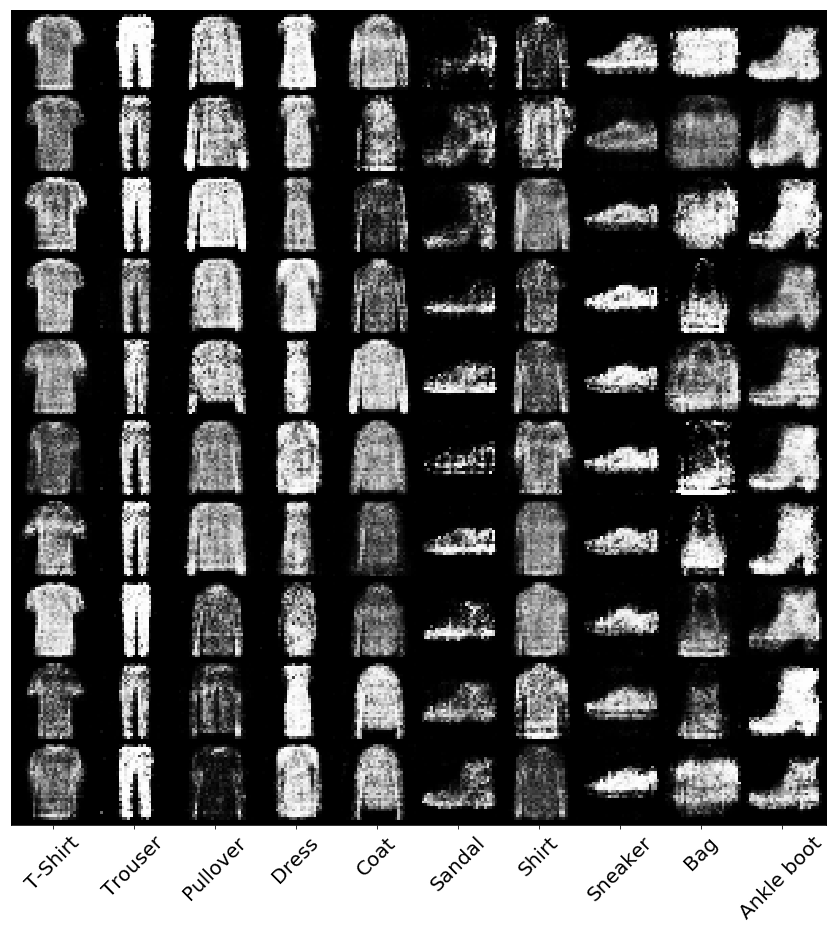

In [12]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)
